In [104]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from statistics import mean

In [105]:
from gym.wrappers import Monitor

In [106]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [107]:
import math
import copy
from torch.distributions import Categorical
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [108]:
#Hyper-parameters
max_episodes = 1000          # max training episodes
max_timesteps = 250          # max timesteps in one episode
gamma = 0.01                # discount factor
gamma1 = 0.99
epsilon = 0.2                #need to change it to max(advantage)
dkl=1                       #need to change it to KL divergence between old and new policies
Q_r=[]
Q_r1=[]
a=[]
Q=np.zeros((max_timesteps,2))
mutation_power = 0.02#hyper-parameter, set from https://arxiv.org/pdf/1712.06567.pdf
#print(Q)

In [109]:
class CartPoleAI(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Sequential(
                        nn.Linear(4,128, bias=True),
                        nn.ReLU(),
                        nn.Linear(128,2, bias=True),
                        nn.Softmax(dim=1)
                        )

                
        def forward(self, inputs):
            x = self.fc(inputs)
            return x

In [110]:
def init_weights(m):
    
        # nn.Conv2d weights are of shape [16, 1, 3, 3] i.e. # number of filters, 1, stride, stride
        # nn.Conv2d bias is of shape [16] i.e. # number of filters
        
        # nn.Linear weights are of shape [32, 24336] i.e. # number of input features, number of output features
        # nn.Linear bias is of shape [32] i.e. # number of output features
        
        if ((type(m) == nn.Linear) | (type(m) == nn.Conv2d)):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.00)

In [111]:
def behavioural_policy(agents):
    return agent

In [112]:
def KL_divergence(agent1,agent2):
    return KL

In [113]:
def return_random_agents(num_agents):
    
    agents = []
    for _ in range(num_agents):
        
        agent = CartPoleAI()
        
        for param in agent.parameters():
            param.requires_grad = False
            
        init_weights(agent)
        agents.append(agent)
        
        
    return agents

In [114]:
def run_agents(agents):
    
    reward_agents = []
    env = gym.make("CartPole-v0")
    #print("Enter")
    for agent in agents:#There is only one agent in the list. But it is necessary to pass the agents in the form of lists to make it iterable and work on it
        agent.eval()
        #print("HELLLO!!!!!!")
        observation = env.reset()
        r=0
        a.clear()
        Q_r1.clear()
        Q_r.clear()
        for i in range(max_timesteps):
            
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            #print(output_probabilities)
            Q[i][0]=output_probabilities[0]
            Q[i][1]=output_probabilities[1]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            a.append(action)
            new_observation, reward, done, info = env.step(action)
            r+=(gamma1**i)*reward
            Q_r.append(reward)
            observation = new_observation
            if(done):
                break

        reward_agents.append(r)
        #reward_agents.append(s)
        #print("Non-discounted Reward:::",Q_r)
        #for rew in reversed(Q_r):
        #    if rew==Q_r[len(Q_r)-1]:
        #        d_r=0
        #    else:
        #        d_r=rew+gamma1*d_r
        #    Q_r1.insert(0,d_r)
        for i in range(len(Q_r)):
            d_r=0
            c=0
            for j in range(i+1,len(Q_r)):
                d_r+=(gamma1**c)*Q_r[j]
                c+=1
            Q_r1.append(d_r)
            
        
    #print("Exit")
    #Q=Q[~np.all(Q==0,axis=1)]
    #print("Reward:::",reward_agents)
    #print("Probabilities:::",Q)
    #print("Actions:::",a)
    #for i in range()
    #print("Discounted Reward,i.e,Q:::",Q_r1)
    
    
    return reward_agents

In [115]:
def run_target_agents(agents):
    
    reward_agents = []
    env = gym.make("CartPole-v0")
    #print("Enter")
    for agent in agents:#There is only one agent in the list. But it is necessary to pass the agents in the form of lists to make it iterable and work on it
        agent.eval()
        #print("HELLLO!!!!!!")
        observation = env.reset()
        r=0
        s=0
        i=0
        #print("SIZE OF ACTIONS:",len(a),"SIZE OF PROBABILITIES:",Q.shape,"SIZE OF DISCOUNTED REWARDS:",len(Q_r1))
        for i in range(len(Q_r1)):
            
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            L_pi=(output_probabilities[a[i]]/Q[i][a[i]])*Q_r1[i]
            #print("Ratios :",output_probabilities[a[i]]/Q[i][a[i]])
            #print("Q value:",Q_r1[i])
            #print("L_pi",L_pi)
            #surr1= L_pi-(4*max(Q_r1)*gamma*dkl/np.square(1-gamma))
            
            #print(output_probabilities)
            s+=L_pi
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env.step(action)
            #r+=(gamma**i)*reward
            
            #s=s+1
            observation = new_observation

            if(done):
                break
        #print("S:",s)
        #print("Max Q_r1:",max(Q_r1))
        #surr1= s-(4*max(Q_r1)*gamma*dkl/np.square(1-gamma))
        #print("Surr1:",surr1)
        #reward_agents.append(surr1)        
        reward_agents.append(s)
    #print("Exit")
    #print("REWARD AGENTS",reward_agents)
    #print(reward_agents)
    return reward_agents

In [116]:
def alternate_average_score(agent, runs):
    score = 0.
    for i in range(runs):
        score += run_target_agents([agent])[0]
    return score/runs

In [117]:
def return_average_score(agent, runs):
    score = 0.
    for i in range(runs):
        score += run_agents([agent])[0]
    return score/runs

In [118]:
def run_agents_n_times(agents, runs):
    avg_score = []
    for agent in agents:
        if agent==agents[0]:
            avg_score.append(return_average_score(agent,runs))
        else:
            avg_score.append(alternate_average_score(agent,runs))
    return avg_score

In [119]:
def mutate(agent):

    child_agent = copy.deepcopy(agent)
            
    for param in child_agent.parameters():
    
        if(len(param.shape)==4): #weights of Conv2D

            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    for i2 in range(param.shape[2]):
                        for i3 in range(param.shape[3]):
                            
                            param[i0][i1][i2][i3]+= mutation_power * np.random.rand()
                                
                                    

        elif(len(param.shape)==2): #weights of linear layer
            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    
                    param[i0][i1]+= mutation_power * np.random.randn()
                        

        elif(len(param.shape)==1): #biases of linear layer or conv layer
            for i0 in range(param.shape[0]):
                
                param[i0]+=mutation_power * np.random.randn()

    return child_agent

In [120]:
def return_children(agents, sorted_parent_indexes, elite_index):
    
    children_agents = []
    
    #first take selected parents from sorted_parent_indexes and generate N-1 children
    for i in range(len(agents)-1):
        
        selected_agent_index = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
        children_agents.append(mutate(agents[selected_agent_index]))

    #now add one elite
    elite_child = add_elite(agents, sorted_parent_indexes, elite_index)
    children_agents.append(elite_child)
    elite_index=len(children_agents)-1 #it is the last one
    
    return children_agents, elite_index

In [121]:
def add_elite(agents, sorted_parent_indexes, elite_index=None, only_consider_top_n=10):
    
    candidate_elite_index = sorted_parent_indexes[:only_consider_top_n]
    
    if(elite_index is not None):
        candidate_elite_index = np.append(candidate_elite_index,[elite_index])
        
    top_score = None
    top_elite_index = None
    
    for i in candidate_elite_index:
        score = return_average_score(agents[i],runs=5)
        print("Score for elite i ", i, " is ", score)
        
        if(top_score is None):
            top_score = score
            top_elite_index = i
        elif(score > top_score):
            top_score = score
            top_elite_index = i
            
    print("Elite selected with index ",top_elite_index, " and score", top_score)
    
    child_agent = copy.deepcopy(agents[top_elite_index])
    return child_agent

In [122]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [19.836941046095397, 19.027213177

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [45.28433576092384, 44.731652283761456, 44.17338614521359, 43.6094809547612, 43.039879752284044, 42.46452500230711, 41.883358588189004, 41.29632180625152, 40.70335535985002, 40.10439935338386, 39.499393286246324, 38.88827604671346, 38.27098590577117, 37.64746051087997, 37.017636879676736, 36.38145139361286, 35.73883979152814, 35.08973716315974, 34.434077942585596, 33.771795901601614, 33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 2

Discounted Reward,i.e,Q::: [12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7



Generation  2  | Mean rewards:  67.50315193239757  | Mean of top 5:  71.10565931815272
The minimum reward is earned is  11.04506893437505 by the  1 th agent
Top  10  scores [50 55 61 67 19  9 91  1 98 24]
Rewards for top:  [71.38538610134559, 71.13992723280624, 71.04218702786763, 71.0218854179469, 70.93891081079722, 70.88217085249487, 70.81774149804029, 70.7497715472358, 70.73674076135929, 70.71242141732127]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.56179249911955

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [40.70335535985002, 40.10439935338386, 39.499393286246324, 38.88827604671346, 38.27098590577117, 37.64746051087997, 37.017636879676736, 36.38145139361286, 35.73883979152814, 35.08973716315974, 34.434077942585596, 33.771795901601614, 33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238



Generation  3  | Mean rewards:  200.0847045891044  | Mean of top 5:  217.07591624706873
The minimum reward is earned is  18.61685577049607 by the  1 th agent
Top  10  scores [53 25 52 46 20 85  3 43 65 91]
Rewards for top:  [219.90923677745795, 217.9568132312298, 216.55790117824338, 215.48359238173677, 215.47203766667585, 215.30255067240884, 215.11510796791836, 215.07375767324197, 215.03564063751017, 214.80109653372594]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [22.

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [19.02721317787414, 18.2093062



Generation  4  | Mean rewards:  86.05657694015636  | Mean of top 5:  90.15026698077662
The minimum reward is earned is  13.956689722643523 by the  1 th agent
Top  10  scores [25  6  8 40 61 78 33 64 37 29]
Rewards for top:  [91.80892413079034, 90.52545610738314, 89.59877497116084, 89.43871418933081, 89.379465505218, 89.22678505429002, 89.06337617653703, 89.06297054259433, 89.0504489595766, 88.9018732751854]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.4

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,



Generation  5  | Mean rewards:  140.54046146049123  | Mean of top 5:  147.47261695666734
The minimum reward is earned is  19.390836593354635 by the  1 th agent
Top  10  scores [32 78 12 79 76 31 64 39 47 38]
Rewards for top:  [148.283531819098, 147.41721967164395, 147.4078579727459, 147.13450525865284, 147.11997006119603, 146.9852666756963, 146.9809889349046, 146.9485383036234, 146.810373796934, 146.75534231867357]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Score for elite i  64  is  19.012697218396504
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7



Generation  6  | Mean rewards:  473.78783461518657  | Mean of top 5:  590.3731359277963
The minimum reward is earned is  25.700695962682165 by the  1 th agent
Top  10  scores [24 35 17 92 56 32 69 98 71 21]
Rewards for top:  [609.1536729486554, 603.5061035939872, 589.1294460385168, 587.6087456212846, 562.4677114365371, 562.4626555557342, 561.6480276423931, 561.2493243948489, 558.9191580961608, 558.8693845211693]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [38.88827604671346, 38.27098590577117, 37.64746051087997, 37.017636879676736, 36.38145139361286, 35.73883979152814, 35.08973716315974, 34.434077942585596, 33.771795901601614, 33.102824143



Generation  7  | Mean rewards:  171.92815893091026  | Mean of top 5:  188.5537548523943
The minimum reward is earned is  19.76208860552919 by the  1 th agent
Top  10  scores [51 73 84 86 29 72 57 67  1 17]
Rewards for top:  [190.89402389546703, 188.28178335976338, 188.17981245620777, 188.00855371139474, 187.40460083913854, 187.03221772810863, 186.7573604966191, 186.51675362211537, 185.57169275179592, 182.57443102182847]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]


Generation  8  | Mean rewards:  311.9068403276178  | Mean of top 5:  351.04427159562135
The minimum reward is earned is  24.098010572369827 by the  1 th agent
Top  10  scores [32 46 99 49 26 56 38 69 64 45]
Rewards for top:  [357.7005491782547, 351.93766589524125, 349.4362407258673, 348.54268759188454, 347.6042145868589, 346.730198812568

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [34.434077942585596, 33.771795901601614, 33.10282414303193, 32.4270950939

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [43.039879752284044, 42.46452500230711, 41.883358588189004, 41.29632180625152, 40.70335535985002, 40.10439935338386, 39.499393286246324, 38.88827604671346, 38.27098590577117, 37.64746051087997, 37.017636879676736, 36.38145139361286, 35.73883979152814, 35.08973716315974, 34.434077942585596, 33.771795901601614, 33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q:



Generation  10  | Mean rewards:  138.27315701463573  | Mean of top 5:  152.11157105396413
The minimum reward is earned is  12.79763062794301 by the  1 th agent
Top  10  scores [ 6 92 97 80 14 27 21 49 74 81]
Rewards for top:  [153.60081230342948, 152.26782205998393, 152.1222756231564, 151.43290125356916, 151.13404402968163, 151.08542173886087, 149.1007970904906, 147.6879471616579, 147.32345952693967, 146.94862181638655]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072,

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,



Generation  11  | Mean rewards:  397.90895082631397  | Mean of top 5:  468.2118306625187
The minimum reward is earned is  23.13984057101548 by the  1 th agent
Top  10  scores [ 8 63 19  1 56 14  5 85  6 41]
Rewards for top:  [472.09151494409684, 469.3394285435484, 468.92293131210596, 467.05915470728934, 463.64612380555326, 461.7468103318497, 460.77718694375136, 459.94193394423684, 458.28260853919727, 456.898443444403]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [58.2879120066779, 57.86657778452313, 57.44098766113448, 57.01109864761059, 56.5768

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [53.41192248302061, 52.94133584143496, 52.46599579942926, 51.985854342857834, 51.50086297258367, 51.01097269957946, 50.516134039979256, 50.01629701008006, 49.51141112129299, 49.001425375043425, 48.48628825761962, 47.96594773496931, 47.44035124744375, 46.90944570448864, 46.37317747928145, 45.8314924033146, 45.28433576092384, 44.731652283761456, 44.17338614521359, 43.6094809547612, 43.039879752284044, 42.46452500230711, 41.883358588189004, 41.29632180625152, 40.70335535985002, 40.10439935338386, 39.499393286246324, 38.88827604671346, 38.27098590577117, 37.64



Generation  12  | Mean rewards:  100.697144792016  | Mean of top 5:  110.29781553761423
The minimum reward is earned is  27.707158100148366 by the  1 th agent
Top  10  scores [90 89 87 26 93 99 83 18 79 66]
Rewards for top:  [112.54084347984862, 110.86342828461784, 110.7574439537871, 109.26887467708337, 108.05848729273414, 108.03987058593832, 108.0168119692969, 107.48140078620322, 107.32590165187855, 106.94863700896595]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [47.96594773496931, 47.44035124744375, 46.90944570448864, 46.37317747928145, 45.8314924033146, 45.28433576092384, 44.731652283761456, 44.17338614521359, 43.6094809547612, 43.039879752284044, 42.46452500230711, 41.883358588189004, 41.29632180625152, 40.70335535985002, 40.10439935338386, 39.499393286246324, 38.88827604671346, 38.27098590577117, 37.64746051087997, 37.017636879676736, 36.38145139361286, 35.73883979152814, 35.08973716315974, 34.434077942585596, 33.771795901601614, 33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 



Generation  13  | Mean rewards:  474.70125777655016  | Mean of top 5:  579.9406576702276
The minimum reward is earned is  20.538331655070646 by the  1 th agent
Top  10  scores [74 90 95 38 16  9 60 45 80 55]
Rewards for top:  [585.6250821800068, 582.6755547015, 579.5170788094391, 576.0173452607079, 575.8682273994841, 574.5500075284662, 571.3356018664662, 570.7119188437292, 570.3628917109789, 561.0965824536121]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]


Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [33.771795901601614, 33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.56179249

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.0299626

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.46

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Score for elite i  99  is  18

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [55.24767862361889, 54.79563497335241, 54.3390252256085, 53.877803258190404, 53.41192248302061, 52.94133584143496, 52.46599579942926, 51.985854342857834, 51.50086297258367, 51.01097269957946, 50.516134039979256, 50.01629701008006, 49.51141112129299, 49.001425375043425, 48.48628825761962, 47.96594773496931, 47.44035124744375, 46.90944570448864, 46.37317747928145, 45.8314924033146, 45.28433576092384, 44.731652283761456, 44.17338614521359, 43.6094809547612, 43.039879752284044, 42.46452500230711, 41.883358588189004, 41.29632180625152, 40.70

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]


Generation  17  | Mean rewards:  402.53245206578447  | Mean of top 5:  473.63178863153723
The minimum reward is earned is  17.272846679134332 by the  1 th agent
Top  10  scores [29 95 45 80 72 57 38 44 83 12]
Rewards

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [41.29632180625152, 40.70335535985002, 40.10439935338386, 39.499393286246324, 38.88827604671346, 38.27098590577117, 37.64746051087997, 37.017636879676736, 36.38145139361286, 35.73883979152814, 35.08973716315974, 34.434077942585596, 33.771795901601614, 33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.38313761644

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [55.24767862361889, 54.79563497335241, 54.3390252256085, 53.877803258190404, 53.41192248302061, 52.94133584143496, 52.46599579942926, 51.985854342857834, 51.50086297258367, 51.01097269957946, 50.516134039979256, 50.01629701008006, 49.51141112129299, 49.001425375043425, 48.48628825761962, 47.96594773496931, 47.44035124744375, 46.90944570448864, 46.37317747928145, 45.8314924033146, 45.28433576092384, 44.731652283761456, 44.17338614521359, 43.6094809547612, 43.039879752284044, 42.46452500230711, 41.883358588189004, 41.29632180625152, 40.70



Generation  18  | Mean rewards:  230.7023310866303  | Mean of top 5:  249.16715153304767
The minimum reward is earned is  26.78058115356124 by the  1 th agent
Top  10  scores [80 31 21 52 88 18 45 96 93 24]
Rewards for top:  [252.66571025167613, 250.56493882763638, 247.68586560288966, 247.47674445359675, 247.4424985294395, 247.0972761850043, 245.86525765422036, 245.3728188441764, 244.7615490234474, 244.52997655658797]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238, 15.705680661607312, 14.854222890512437, 13.994164535871148, 13.12541872310217, 12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [40.70335535985002, 40.10439935338386, 39.499393286246324, 38.88827604671346, 38.27098590577117, 37.64746051087997, 37.017636879676736, 36.38145139361286, 35.73883979152814, 35.08973716315974, 34.434077942585596, 33.771795901601614, 33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 23.765728565289617, 22.995685419484463, 22.217864060085315, 21.432185919278098, 20.63857163563444, 19.836941046095397, 19.02721317787414, 18.20930624027691, 17.383137616441324, 16.548623854991238



Generation  19  | Mean rewards:  191.94561709574648  | Mean of top 5:  210.0544345794088
The minimum reward is earned is  29.077695674020447 by the  1 th agent
Top  10  scores [11 52  8 67 77 84 29  1 97 20]
Rewards for top:  [212.2985998902208, 210.0123040122211, 209.84868656286847, 209.19916412864305, 208.91341830309054, 208.64577103387106, 208.64206070613739, 208.0588538164864, 207.81673686411696, 207.69084271014447]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [12.247897700103202, 11.361512828387072, 10.466174574128356, 9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.940399, 2.9701, 1.99, 1.0, 0]
Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [28.94467727277075, 28.2269467401

Non-discounted Reward::: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Discounted Reward,i.e,Q::: [45.28433576092384, 44.731652283761456, 44.17338614521359, 43.6094809547612, 43.039879752284044, 42.46452500230711, 41.883358588189004, 41.29632180625152, 40.70335535985002, 40.10439935338386, 39.499393286246324, 38.88827604671346, 38.27098590577117, 37.64746051087997, 37.017636879676736, 36.38145139361286, 35.73883979152814, 35.08973716315974, 34.434077942585596, 33.771795901601614, 33.10282414303193, 32.42709509397165, 31.744540498961264, 31.055091413092185, 30.35867819504261, 29.655230500043043, 28.94467727277075, 28.226946740172476, 27.501966404214624, 26.769663034560228, 26.029962661171947, 25.28279056684035, 24.52807127963672, 2

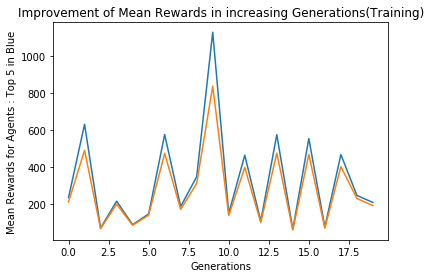

In [123]:
game_actions = 2 #2 actions possible: left or right

#disable gradients as we will not use them
torch.set_grad_enabled(False)

# initialize N number of agents
num_agents = 100
agents = return_random_agents(num_agents)

# How many top agents to consider as parents
top_limit = 10

# run evolution until X generations
generations = 20

elite_index = None
n=[]
m=[]

for generation in range(generations):

    # return rewards of agents
    rewards = run_agents_n_times(agents, 3) #return average of 3 runs later
    #print(rewards)
    #sort by rewards
    sorted_parent_indexes = np.argsort(rewards)[::-1][:top_limit] #reverses and gives top values (argsort sorts by ascending by default) https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
    print("")
    print("")
    top_rewards = []
    
    for best_parent in sorted_parent_indexes:
        top_rewards.append(rewards[best_parent])
    
    print("Generation ", generation, " | Mean rewards: ", np.mean(rewards), " | Mean of top 5: ",np.mean(top_rewards[:5]))
    #print(rewards)
    print("The minimum reward is earned is ",min(rewards),"by the ",rewards.index(min(rewards))+1,"th agent")
    print("Top ",top_limit," scores", sorted_parent_indexes)
    print("Rewards for top: ",top_rewards)
    
    m.append(np.mean(top_rewards))
    n.append(np.mean(rewards))
    # setup an empty list for containing children agents
    children_agents, elite_index = return_children(agents, sorted_parent_indexes, elite_index)

    # kill all agents, and replace them with their children
    agents = children_agents
x=np.arange(generations)
plt.plot(x,m)
plt.plot(x,n)
plt.title('Improvement of Mean Rewards in increasing Generations(Training)')
plt.ylabel('Mean Rewards for Agents : Top 5 in Blue')
plt.xlabel('Generations')
plt.show()

In [124]:
def play_agent(agent):
        env = gym.make("CartPole-v0")
        
        env_record = Monitor(env, './video', force=True)
        observation = env_record.reset()
        last_observation = observation
        r=0
        j=[]
        episode_durations=[]
        timestep=0
        for timestep in range(1000):
            env_record.render()
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env_record.step(action)
            r=r+reward
            j.append(r)
            observation = new_observation

            if(done):
                break

        env_record.close()

        print("Total Collected Rewards: ",r)

In [125]:
play_agent(agents[0])

Total Collected Rewards:  15.0
